# Quick and dirty way to plot all installed turbines in Denmark
Authors: Karen Pardos Olsen, DTU Elektro <br>
Date: Nov 20 2018 <br>
Requires: python packages basemap, pyproj, utm

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from mpl_toolkits.basemap import pyproj
from mpl_toolkits.basemap import Basemap
import utm as utm
fs = 15
mpl.rcParams['xtick.labelsize'] = fs
mpl.rcParams['axes.labelweight'] = 500
mpl.rcParams['ytick.labelsize'] = fs
mpl.rcParams['axes.labelsize']=fs

In [3]:
# Load turbine positions
file_path = "data/"
Xcoord = pd.read_table(file_path+'Xcoord.txt',skiprows=1,names=['Xcoord'],engine='python',skip_blank_lines=False)
Ycoord = pd.read_table(file_path+'Ycoord.txt',skiprows=1,names=['Ycoord'],engine='python',skip_blank_lines=False)
capacity = pd.read_table(file_path+'Kapacitet.txt',skiprows=1,names=['capacity'],engine='python',skip_blank_lines=False)
communenr = pd.read_table(file_path+'Kommune-nr.txt',skiprows=1,names=['communenr'],engine='python')
data_df = pd.concat([capacity,Xcoord,Ycoord,communenr],axis=1)
data_df = data_df[data_df['Xcoord'].isnull() == False].reset_index(drop=True)

In [4]:
# Convert coordinates from UTM 32 to latitude and longitude
lat, lon = np.zeros(len(data_df)),np.zeros(len(data_df))
for _ in range(len(data_df)):
    try:
        lat[_],lon[_] = utm.to_latlon(data_df['Xcoord'][_],data_df['Ycoord'][_], 32, 'U')
    except:
        lat[_],lon[_] = 0,0
data_df['lat'] = lat
data_df['lon'] = lon
mask = np.array([(data_df['lat'] != 0) & (data_df['communenr'] != 0)])[0]
data_df = data_df[mask].reset_index(drop=True)
print('%s turbines placements found!' % len(data_df))

5629 turbines placements found!


In [5]:
# Split into dataframes of different regions
data_df_DK1 = data_df[data_df['communenr'] > 400].copy().reset_index(drop=True)
data_df_DK2 = data_df[data_df['communenr'] <= 400].copy().reset_index(drop=True)
data_df_BO = data_df[data_df['communenr'] == 400].copy().reset_index(drop=True)

In [6]:
# Find center position, weighted by capacity and max distance from weighted center in each region
mean_x,mean_y = np.sum(data_df['Xcoord'].values*data_df['capacity'].values)/np.sum(data_df['capacity'].values),np.sum(data_df['Ycoord'].values*data_df['capacity'].values)/np.sum(data_df['capacity'].values)
r_mean_DK = np.mean(np.sqrt((data_df['Xcoord'].values-mean_x)**2 + (data_df['Ycoord'].values-mean_y)**2))
r_max_DK = np.max(np.sqrt((data_df['Xcoord'].values-mean_x)**2 + (data_df['Ycoord'].values-mean_y)**2))
mean_lat_DK,mean_lon_DK = utm.to_latlon(mean_x,mean_y, 32, 'U')

mean_x,mean_y = np.sum(data_df_DK1['Xcoord'].values*data_df_DK1['capacity'].values)/np.sum(data_df_DK1['capacity'].values),np.sum(data_df_DK1['Ycoord'].values*data_df_DK1['capacity'].values)/np.sum(data_df_DK1['capacity'].values)
r_mean_DK1 = np.mean(np.sqrt((data_df_DK1['Xcoord'].values-mean_x)**2 + (data_df_DK1['Ycoord'].values-mean_y)**2))
r_max_DK1 = np.max(np.sqrt((data_df_DK1['Xcoord'].values-mean_x)**2 + (data_df_DK1['Ycoord'].values-mean_y)**2))
mean_lat_DK1,mean_lon_DK1 = utm.to_latlon(mean_x,mean_y, 32, 'U')

mean_x,mean_y = np.sum(data_df_DK2['Xcoord'].values*data_df_DK2['capacity'].values)/np.sum(data_df_DK2['capacity'].values),np.sum(data_df_DK2['Ycoord'].values*data_df_DK2['capacity'].values)/np.sum(data_df_DK2['capacity'].values)
r_mean_DK2 = np.mean(np.sqrt((data_df_DK2['Xcoord'].values-mean_x)**2 + (data_df_DK2['Ycoord'].values-mean_y)**2))
r_max_DK2 = np.max(np.sqrt((data_df_DK2['Xcoord'].values-mean_x)**2 + (data_df_DK2['Ycoord'].values-mean_y)**2))
mean_lat_DK2,mean_lon_DK2 = utm.to_latlon(mean_x,mean_y, 32, 'U')

mean_x,mean_y = np.sum(data_df_BO['Xcoord'].values*data_df_BO['capacity'].values)/np.sum(data_df_BO['capacity'].values),np.sum(data_df_BO['Ycoord'].values*data_df_BO['capacity'].values)/np.sum(data_df_BO['capacity'].values)
r_mean_BO = np.mean(np.sqrt((data_df_BO['Xcoord'].values-mean_x)**2 + (data_df_BO['Ycoord'].values-mean_y)**2))
r_max_BO = np.max(np.sqrt((data_df_BO['Xcoord'].values-mean_x)**2 + (data_df_BO['Ycoord'].values-mean_y)**2))
mean_lat_BO,mean_lon_BO = utm.to_latlon(mean_x,mean_y, 32, 'U')

print(r_max_DK/1000.,r_max_DK1/1000.,r_max_DK2/1000.,r_max_BO/1000.)

352.72275224182556 188.1982692328433 221.6798995552033 21.783353019247706


In [7]:
# Set up function that plots a circle
def plot_circle(m,r_km,center,color):
    
    lons, lats, xs, ys = m.makegrid(200, 200, returnxy=True)

    gc = pyproj.Geod(a=m.rmajor, b=m.rminor)

    distances = np.zeros(lons.size)

    for k, (lo, la) in enumerate(zip(lons.flatten(), lats.flatten())):
        _, _, distances[k] = gc.inv(center[0], center[1], lo, la)

    distances = distances.reshape(200, 200)  # In km.

    # Plot perimeters of equal distance.
    levels = [r_km]  # [50, 100, 150]
    cs = m.contour(xs, ys, distances, levels, colors=color)

/home/karen/code/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1704: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/home/karen/code/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


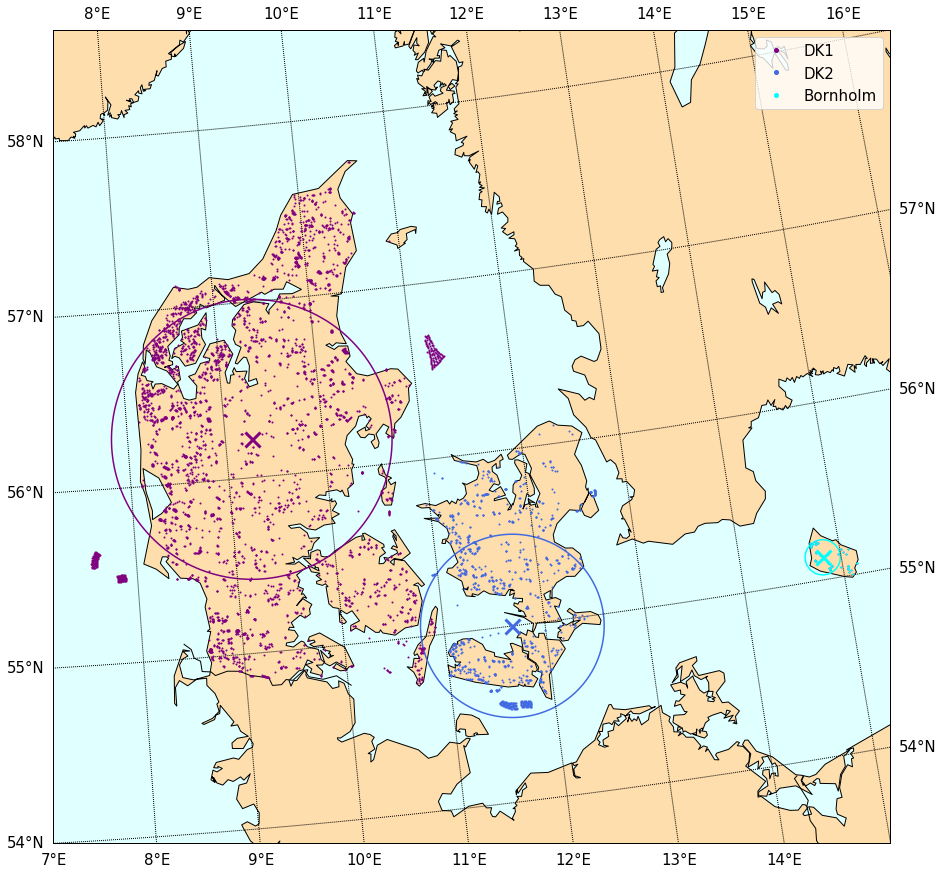

In [8]:
fig, ax = plt.subplots(figsize=(15, 15))
m = Basemap(llcrnrlon=7,llcrnrlat=54,urcrnrlon=16.5,urcrnrlat=58,
            resolution='i',projection='tmerc',lon_0=9.5,lat_0=56, epsg=5520)#,epsg = 23032)

# Color basemap
m.drawcoastlines()
m.fillcontinents(color='navajowhite',lake_color='lightcyan')
m.drawmapboundary(fill_color='lightcyan')
# m.etopo('ESRI_Imagery_World_2D',scale=0.5, alpha=0.5)
# m.arcgisimage(service =  "ESRI_Imagery_World_2D", xpixels = 2000, alpha=0.05)
m.drawcountries(color="black", linewidth=1)
# m.drawrivers(linewidth=0.5,color="blue")

# Draw parallels and meridians, labels = [left,right,top,bottom]
m.drawparallels(np.arange(30,61.,1.),labels=[True,True,False,False], fontsize=15)
m.drawmeridians(np.arange(0.,21.,1.),labels=[False,False,True,True], fontsize=15)

# Plot positions of turbines
mlon,mlat = m(data_df['lon'].values, data_df['lat'].values)
m.plot(mlon[data_df['communenr'].values > 400],mlat[data_df['communenr'].values > 400], '.', color='purple', ms=2, label='DK1') # DK1
m.plot(mlon[data_df['communenr'].values <= 400],mlat[data_df['communenr'].values <= 400], '.', color='royalblue', ms=2, label='DK2') # DK2
m.plot(mlon[data_df['communenr'].values == 400],mlat[data_df['communenr'].values == 400], '.', color='cyan', ms=2, label='Bornholm') # BO

# Plot mean positions
mean_mlon_DK1,mean_mlat_DK1 = m(mean_lon_DK1,mean_lat_DK1)
m.plot(mean_mlon_DK1,mean_mlat_DK1, 'x', color='purple', ms=15, mew=3) # DK1
mean_mlon_DK2,mean_mlat_DK2 = m(mean_lon_DK2,mean_lat_DK2)
m.plot(mean_mlon_DK2,mean_mlat_DK2, 'x', color='royalblue', ms=15, mew=3) # DK2
mean_mlon_BO,mean_mlat_BO = m(mean_lon_BO,mean_lat_BO)
m.plot(mean_mlon_BO,mean_mlat_BO, 'x', color='cyan', ms=15, mew=3) # BO

plot_circle(m,r_mean_DK1,[mean_lon_DK1,mean_lat_DK1],'purple')
plot_circle(m,r_mean_DK2,[mean_lon_DK2,mean_lat_DK2],'royalblue')
plot_circle(m,r_mean_BO,[mean_lon_BO,mean_lat_BO],'cyan')

lgnd = plt.legend(loc='upper right',fontsize=15)
[lgnd.legendHandles[_]._legmarker.set_markersize(8) for _ in range(len(lgnd.legendHandles))]

# plt.savefig('turbine_placement_mean_r.pdf',format='pdf',dpi=300)
plt.savefig('turbine_placement_mean_r.png',format='png',dpi=300)